In [ ]:
!nvidia-smi # Check whether your system has a GPU

In [ ]:
!pip install numpy --upgrade

# Import packages

In [1]:
import numpy as np
import cv2
import torch 
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F

numpy 
- A scientific computing library
- Supports array operations and manipulations
- Built-in functions like array sum, diff, mean, average, min, max etc.

cv2
- To read and write images
- To perform basic vision algorithms like RGB to HSV, Gaussian Blur, Dilation, Histogram, Shape detection etc.

torch
- The open source ML framework for deep learning
- Has a pythonic interface

torchvision
- consists of popular datasets, model architectures, and common image transformations for computer vision
- Contains built in data augmentations

matplotlib
- It is a data visualization library for python
- It supports graphical plotting and viewing images and other data

nn
- The base module with which we can create and train neural nets
- Provides built-in classes for common neural network layers like Conv, Pooling, Activations, Normalizations, Dropout etc.

optim
- It is a package for implementing various optimization algorithms for model training
- Built-in optimizers like SGD, Adam, Adagrad, RMSprop etc.

# Preprocess inputs

In [2]:
transform = transforms.Compose([transforms.ToTensor()]) # Define the set of transformations to be applied on the input data

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

ToTensor()
 - converts the image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]

Normalize() 
- output[channel] = (input[channel] - mean[channel]) / std[channel]

- Normalization helps get data within a range and reduces the skewness which helps learn faster and better. 
- Normalization can also tackle the diminishing and exploding gradients problems.

# Create Dataloaders

- Combines a dataset and a sampler
- Provides an iterable over the given dataset
- Supports single- or multi-process loading
- Customizing loading order
- Automatic batching

In [3]:
trainset = datasets.CIFAR10('trainset', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [4]:
valset = datasets.CIFAR10('testset', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [5]:
dataiter = iter(trainloader)


Now that we have an iterator, let's visualize our data

In [6]:
#images, gt_labels = dataiter.next() # The first minibatch of data
images, gt_labels  = next(dataiter)

In [7]:
print(images.shape)
print(gt_labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


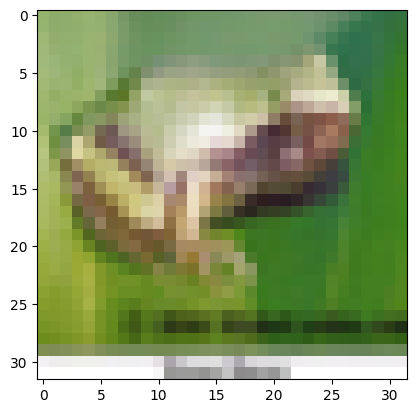

In [14]:
 # Visualize an image sample
plt.imshow((images[1].squeeze()).permute(1,2,0).numpy())


In [15]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

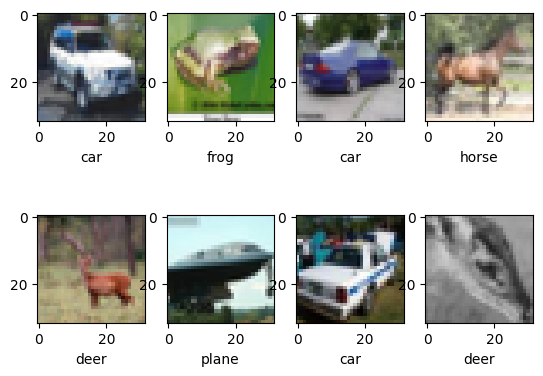

In [20]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    ax = plt.subplot(2, 4, index)
    ax.set_xlabel(classes[gt_labels[index-1].item()])
    # plt.axis('off')
    plt.imshow(images[index-1].squeeze().permute(1,2,0).numpy())

In [21]:
# Visualize the Ground truth labels
print(gt_labels)

tensor([1, 6, 1, 7, 4, 0, 1, 4, 8, 1, 7, 4, 1, 3, 2, 0, 4, 5, 0, 6, 3, 4, 0, 1,
        9, 7, 6, 2, 9, 9, 7, 0])


In [22]:
# Visualize the onehot encoding of the labels
onehot_labels = nn.functional.one_hot(gt_labels, num_classes=10)
print(onehot_labels)

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],


### Create a Model for CIFAR-10 Classification

In [32]:
class CIFARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
model = CIFARModel()

In [36]:
print(model)

CIFARModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Visualize the probabilities of a sample image

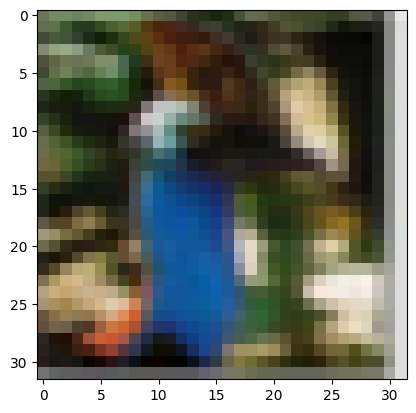

In [37]:
# see a sample image
plt.imshow(images[0].squeeze().permute(1,2,0).numpy())

In [40]:
# print the ground truth label
print(gt_labels[0])

tensor(2)


In [41]:
# print the ground truth onehot representation
print(onehot_labels[0])

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


# Better Training Loops

- Add a progress bar for the training
- After each epoch, validate the model to see if the model has converged or whether it is overfit


In [42]:
model = CIFARModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 2
pbar = tqdm(range(epochs))
best_accuracy = 0.0

  0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
time_init = time() # record the time at which training started

for e in pbar:
    running_loss = 0
    for images, gt_labels in tqdm(trainloader):
        # Flatten MNIST images into a 784 long vector
        images = images.cpu()
        gt_labels = gt_labels.cpu()
    
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()
    average_loss = running_loss/len(trainloader)
    
    # perform validation
    correct_count = 0
    total_count = 0
    for images,gt_labels in valloader:
      pred_probs = model(images.cpu())
      predicted_labels = torch.argmax(pred_probs, dim=-1)

      for i in range(len(gt_labels)):
        if predicted_labels[i]==gt_labels[i]:
          correct_count = correct_count+1
        total_count = total_count+1       

    accuracy = correct_count/total_count
    
    # save the model weights
    if accuracy>=best_accuracy:
      best_accuracy = accuracy
      torch.save(model, './best_cifar_model.pt')
    torch.save(model, './last_cifar_model.pt') 

    print(f"\nEpoch {e} - Training loss: {average_loss}, val accuracy : {accuracy}")
print(f"Training Time (in minutes) = {(time()-time_init)/60}")

 50%|█████     | 1/2 [00:30<00:30, 30.49s/it]


Epoch 0 - Training loss: 2.1339239599761184, val accuracy : 0.3299


100%|██████████| 2/2 [00:46<00:00, 23.34s/it]


Epoch 1 - Training loss: 1.7114412491701385, val accuracy : 0.4352
Training Time (in minutes) = 0.5497672120730083


# Model Validation

In [44]:
images, gt_labels = next(iter(valloader))

with torch.no_grad():
    pred_probs = model(images.cpu())

predicted_labels = torch.argmax(pred_probs, dim=-1)

### Lets visualize the validation input images

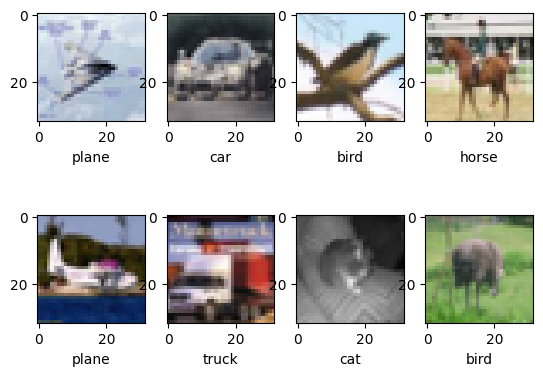

In [45]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    ax = plt.subplot(2, 4, index)
    ax.set_xlabel(classes[gt_labels[index-1].item()])
    # plt.axis('off')
    plt.imshow(images[index-1].squeeze().permute(1,2,0).numpy())

Ground truth class labels

In [46]:
print(f"Ground truth labels : {gt_labels}")

Ground truth labels : tensor([0, 1, 2, 7, 0, 9, 3, 2, 5, 2, 9, 5, 4, 4, 3, 6, 3, 2, 5, 6, 4, 5, 0, 3,
        3, 3, 5, 2, 4, 1, 1, 5])


Predicted class labels

In [47]:
print(f"Predicted labels : {predicted_labels}",)

Predicted labels : tensor([0, 1, 0, 7, 1, 1, 3, 2, 5, 2, 8, 1, 6, 5, 5, 9, 5, 4, 5, 4, 3, 3, 1, 9,
        3, 0, 3, 6, 3, 3, 8, 2])


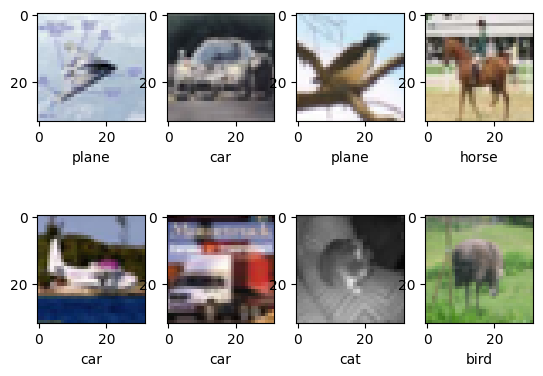

In [48]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    ax = plt.subplot(2, 4, index)
    ax.set_xlabel(classes[predicted_labels[index-1].item()])
    # plt.axis('off')
    plt.imshow(images[index-1].squeeze().permute(1,2,0).numpy())

In [49]:
correct_count = 0
total_count = 0
for i in range(len(gt_labels)):
  img = images[i]
  if predicted_labels[i]==gt_labels[i]:
    correct_count = correct_count+1
  total_count = total_count+1
accuracy = correct_count/total_count
print(f"The accuracy on the minibatch is : {accuracy}")

The accuracy on the minibatch is : 0.28125


In [50]:
correct_count = 0
total_count = 0

for images,gt_labels in valloader:
  pred_probs = model(images.cpu())
  predicted_labels = torch.argmax(pred_probs, dim=-1)

  for i in range(len(gt_labels)):
    if predicted_labels[i]==gt_labels[i]:
      correct_count = correct_count+1
    total_count = total_count+1       

accuracy = correct_count/total_count
print(f"Number of validation images = {total_count}\n")
print(f"Model Accuracy = {accuracy}")

Number of validation images = 10000

Model Accuracy = 0.4352
